In [126]:
%matplotlib inline
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from langdetect import detect
import langdetect
from sklearn.model_selection import train_test_split,cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
import en_core_web_lg
from tqdm import tqdm_pandas, tqdm_notebook
import tokenize_uk
import warnings

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_colwidth', 400)

In [2]:
nlp = en_core_web_lg.load()

# Loading data

In [6]:
df = pd.read_csv('scraper/data-phones.csv.gz', compression='gzip')
df['review'] = df['review'].apply(json.loads)
#df['scores'] = df['scores'].apply(json.loads)
print("Rows: ", len(df))
df.head()

Rows:  49890


,review,id,scores
0,{'_': 'Пришел не рабочий телефон. Самостоятельно выключается. При включении на экране белая поло...,18896982,NaN
1,{'_': 'Не розумію..... це підробка??? Адже якщо мені не зраджує пам*ять iPhone6 випускався лише ...,18840918,NaN
2,"{'_': 'Чудовий телефон , приємні знижки та якісне обслуговування', 'Переваги:': 'Легкий,швидкий,...",18780426,5.0
3,{'_': 'Он полностю новий?'},18736812,5.0
4,"{'_': 'Телефон и правда ещё очень актуальный сам пользуюсь и рад производительности,второй 5s та...",18534645,4.0


For now just stick with main part of review

In [314]:
df['main_review'] = df['review'].apply(lambda x: x['_'])
df.head()

,review,id,scores,main_review
0,{'_': 'Пришел не рабочий телефон. Самостоятельно выключается. При включении на экране белая поло...,18896982,NaN,Пришел не рабочий телефон. Самостоятельно выключается. При включении на экране белая полоска и з...
1,{'_': 'Не розумію..... це підробка??? Адже якщо мені не зраджує пам*ять iPhone6 випускався лише ...,18840918,NaN,Не розумію..... це підробка??? Адже якщо мені не зраджує пам*ять iPhone6 випускався лише в трьох...
2,"{'_': 'Чудовий телефон , приємні знижки та якісне обслуговування', 'Переваги:': 'Легкий,швидкий,...",18780426,5.0,"Чудовий телефон , приємні знижки та якісне обслуговування"
3,{'_': 'Он полностю новий?'},18736812,5.0,Он полностю новий?
4,"{'_': 'Телефон и правда ещё очень актуальный сам пользуюсь и рад производительности,второй 5s та...",18534645,4.0,"Телефон и правда ещё очень актуальный сам пользуюсь и рад производительности,второй 5s так же пр..."


Filter those written in ukrainian

In [315]:
def detect_lang(x):
    try:
        return detect(x)
    except langdetect.lang_detect_exception.LangDetectException:
        pass
        
df_uk = df[df['main_review'].progress_apply(detect_lang) == 'uk'].copy()
print("Rows: ", len(df_uk))
df_uk.head()


Rows:  10231


,review,id,scores,main_review
0,{'_': 'Пришел не рабочий телефон. Самостоятельно выключается. При включении на экране белая поло...,18896982,NaN,Пришел не рабочий телефон. Самостоятельно выключается. При включении на экране белая полоска и з...
1,{'_': 'Не розумію..... це підробка??? Адже якщо мені не зраджує пам*ять iPhone6 випускався лише ...,18840918,NaN,Не розумію..... це підробка??? Адже якщо мені не зраджує пам*ять iPhone6 випускався лише в трьох...
2,"{'_': 'Чудовий телефон , приємні знижки та якісне обслуговування', 'Переваги:': 'Легкий,швидкий,...",18780426,5.0,"Чудовий телефон , приємні знижки та якісне обслуговування"
3,{'_': 'Он полностю новий?'},18736812,5.0,Он полностю новий?
4,"{'_': 'Телефон и правда ещё очень актуальный сам пользуюсь и рад производительности,второй 5s та...",18534645,4.0,"Телефон и правда ещё очень актуальный сам пользуюсь и рад производительности,второй 5s так же пр..."


Leave only those with scores

In [318]:
main_key = 'Общее впечатление'
taste_key = 'Соответствие вкуса'
aroma_key = 'Соответствие аромата'
def combine_scores(scores):
    if main_key in scores:
        main = scores.get(main_key)
        taste = scores.get(taste_key)
        aroma = scores.get(aroma_key)
        raws = list(filter(lambda x: x, [main, taste, aroma]))
        return np.mean(raws)
df_uk = df_uk.assign(score_raw=df_uk['scores'])
df_ws = df_uk[pd.notna(df_uk['score_raw'])].copy()
print("Rows: ", len(df_ws))
df_ws.head()

Rows:  4317


,review,id,scores,main_review,score_raw
2,"{'_': 'Чудовий телефон , приємні знижки та якісне обслуговування', 'Переваги:': 'Легкий,швидкий,...",18780426,5.0,"Чудовий телефон , приємні знижки та якісне обслуговування",5.0
12,{'_': 'Запитання: чи є в ньому функцію запису телефонної розмови?'},19373305,4.0,Запитання: чи є в ньому функцію запису телефонної розмови?,4.0
15,{'_': 'Користуюсь два тижні. Достойний телефон. Працює швидкоі і злагоджено. Дуже зручно зі скан...,21074865,5.0,"Користуюсь два тижні. Достойний телефон. Працює швидкоі і злагоджено. Дуже зручно зі сканером, х...",5.0
22,"{'_': 'Підскажи який стоїть Андроїд? І чи є до нього захисне скло і чохол?', 'Недоліки:': '-'}",20476907,5.0,Підскажи який стоїть Андроїд? І чи є до нього захисне скло і чохол?,5.0
60,"{'_': 'Користуюсь вже два місяці, телефон крутий, тільки одна порада не купляйте джет блек, а пр...",16161182,5.0,"Користуюсь вже два місяці, телефон крутий, тільки одна порада не купляйте джет блек, а простий ч...",5.0


Digitize scores

In [349]:
def digitize(n):
    if (1 <= n) and (n < 3):
        return 0
    elif (3 <= n) and (n < 4):
        return 1
    elif (4 <= n) and (n <= 5):
        return 2
    else:
        return None
bins = 1+np.array([4/3,2*4/3])
df_ws['score'] = np.digitize(df_ws['score_raw'], bins)
df_ws.head()

,review,id,scores,main_review,score_raw,score
2,"{'_': 'Чудовий телефон , приємні знижки та якісне обслуговування', 'Переваги:': 'Легкий,швидкий,...",18780426,5.0,"Чудовий телефон , приємні знижки та якісне обслуговування",5.0,2
12,{'_': 'Запитання: чи є в ньому функцію запису телефонної розмови?'},19373305,4.0,Запитання: чи є в ньому функцію запису телефонної розмови?,4.0,2
15,{'_': 'Користуюсь два тижні. Достойний телефон. Працює швидкоі і злагоджено. Дуже зручно зі скан...,21074865,5.0,"Користуюсь два тижні. Достойний телефон. Працює швидкоі і злагоджено. Дуже зручно зі сканером, х...",5.0,2
22,"{'_': 'Підскажи який стоїть Андроїд? І чи є до нього захисне скло і чохол?', 'Недоліки:': '-'}",20476907,5.0,Підскажи який стоїть Андроїд? І чи є до нього захисне скло і чохол?,5.0,2
60,"{'_': 'Користуюсь вже два місяці, телефон крутий, тільки одна порада не купляйте джет блек, а пр...",16161182,5.0,"Користуюсь вже два місяці, телефон крутий, тільки одна порада не купляйте джет блек, а простий ч...",5.0,2


In [128]:
#train,test = train_test_split(df_ws, test_size=0.3)
#train.to_csv('train.phones.csv', index=False)
#test.to_csv('test.phones.csv', index=False)
train = pd.read_csv('train.phones.csv.gz', compression='gzip')
train = train.assign(review_dict = train['review'].apply(ast.literal_eval))
test = pd.read_csv('test.phones.csv.gz', compression='gzip')
test = test.assign(review_dict = test['review'].apply(ast.literal_eval))

Load ukranian stemmer (borrowed from https://github.com/Amice13/ukr_stemmer)

In [4]:
%run -n ukr_stemmer3.py

In [5]:
def stem(xs):
    return np.array([UkrainianStemmer(x).stem_word() for x in xs])

def stem_all(X):
    stem_vec = np.vectorize(stem)
    return stem_vec(X)

In [6]:
def tokenize(x, lowercase=False):
    tokens = tokenize_uk.tokenize_words(x)
    if lowercase==True:
        return [tok.lower() for tok in tokens]
    else:
        return tokens

In [130]:
train = train.assign(review_doc = train['main_review'].apply(lambda x: stem(tokenize(x, lowercase=True))))
test = test.assign(review_doc = test['main_review'].apply(lambda x: stem(tokenize(x, lowercase=True))))

In [8]:
vocab = CountVectorizer(tokenizer=lambda x: x, lowercase=False).fit(train['review_doc'], train['score']).vocabulary_
idxs, ivocab = zip(*sorted(zip(vocab.values(),vocab.keys())))
ivocab = np.array(ivocab)

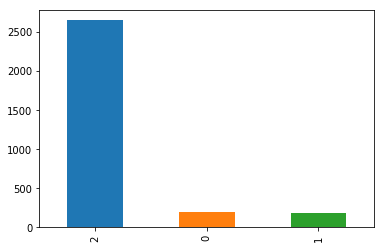

In [9]:
train['score'].value_counts().plot(kind='bar')

# Classification

### Metrics
This task has 3 classes, so simple f1/prec/rec metrics will not be representative. Also the data is substantially skewed towards the `positive` class. I assume that the end user of this classification will want to find the nagative comments and somehow react to them. He, definitely, will not want to look at enourmous number of positive posts. So our metric will target negative class. In addition, we, really, don't care if some positive class was classified as negative, because it is easy to find such error. On the other side, the cost of not labeling negative comment with negative class is huge, there is just no way for user to find this error in the big pile of positive classes. 

I have chosen `F2` score measured for negative class. Also we will look at other compound metrics to not make them too bad

In [190]:
from sklearn.metrics import fbeta_score, make_scorer

f2_score = make_scorer(fbeta_score, beta=2, labels=[0], average=None)

def print_metrics(cls, X, y):
    scores = cross_validate(cls, X, y=y,
                            scoring={'f2_score': f2_score, 
                                     'f1_macro': 'f1_macro',
                                     'accuracy': 'accuracy',
                                     'precision_macro': 'precision_macro',
                                     'recall_macro': 'recall_macro'}, 
                            return_train_score=True, 
                            cv=3)

    
    df = pd.DataFrame(scores)
    print(confusion_matrix(y, cls.predict(X)))
#    print(confusion_matrix(train['score']))
    print(df[['test_f2_score', 'train_accuracy', 'test_accuracy', 'test_f1_macro', 'test_precision_macro', 'test_recall_macro']].mean())
    return df

## Originial dataset

### Naive Bayes

In [173]:
p1 = Pipeline([('vectorizer', CountVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
               ('classifier', MultinomialNB())])
p1.fit(train['review_doc'], train['score'])
print_metrics(p1, train['review_doc'], train['score'])

[[  85    0  109]
 [   3   43  138]
 [   4    6 2633]]
test_f2_score           0.043795
train_accuracy          0.897053
test_accuracy           0.870902
test_f1_macro           0.332162
test_precision_macro    0.412804
test_recall_macro       0.342930
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.093123,0.233095,0.873016,0.338997,0.056391,0.459000,0.347205,0.893194,0.482793,0.257353,0.908459,0.432629
1,0.130927,0.230437,0.870904,0.337783,0.055762,0.404203,0.346069,0.900199,0.536405,0.350719,0.916292,0.471671
2,0.096630,0.232796,0.868787,0.319708,0.019231,0.375209,0.335515,0.897767,0.521826,0.298373,0.944409,0.458410


### Logistic Regression

In [174]:
from sklearn.linear_model import LogisticRegression

lr_p = Pipeline([('vectorizer', CountVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
                 ('classifier', LogisticRegression())])
lr_p.fit(train['review_doc'], train['score'])
print_metrics(lr_p, train['review_doc'], train['score'])

[[ 173    0   21]
 [   1  138   45]
 [   0    0 2643]]
test_f2_score           0.260687
train_accuracy          0.981628
test_accuracy           0.873883
test_f1_macro           0.445926
test_precision_macro    0.529707
test_recall_macro       0.421424
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.172937,0.234779,0.874008,0.440265,0.323129,0.485892,0.423580,0.980626,0.939174,0.911252,0.992782,0.895518
1,0.214584,0.243432,0.873883,0.454133,0.279720,0.565038,0.424211,0.982622,0.945574,0.937008,0.993508,0.906410
2,0.197103,0.299739,0.873757,0.443381,0.179211,0.538191,0.416479,0.981638,0.943187,0.911950,0.993144,0.901772


### SVM

In [14]:
from sklearn.svm import SVC

svm_p = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
                 ('classifier', SVC())])
svm_p.fit(train['review_doc'], train['score'])
print_metrics(svm_p, train['review_doc'], train['score'])

[[   0    0  194]
 [   0    0  184]
 [   0    0 2643]]
test_f2_score           0.000000
train_accuracy          0.874876
test_accuracy           0.874876
test_f1_macro           0.311088
test_precision_macro    0.291625
test_recall_macro       0.333333
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.388919,0.846454,0.874008,0.310923,0.0,0.291336,0.333333,0.875310,0.311170,0.0,0.291770,0.333333
1,0.398781,0.892271,0.874876,0.311088,0.0,0.291625,0.333333,0.874876,0.311088,0.0,0.291625,0.333333
2,0.404449,0.909296,0.875746,0.311252,0.0,0.291915,0.333333,0.874442,0.311005,0.0,0.291481,0.333333


###  Tonal dictionary classifier

loading tonal dict

In [15]:
tonal_dict = {}
with open('tone-dict-uk.tsv') as f:
    for line in f.readlines():
        word, ts = line.strip().split('\t')
        tonal_dict[UkrainianStemmer(word.lower()).stem_word()] = int(ts)

In [16]:
class TonalClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, vocab, tonal_dict):
        self.vocab = vocab
        self.tonal_dict = tonal_dict
        self.ivocab = np.zeros((len(vocab),))
        for w,i in vocab.items():
            self.ivocab[i] = tonal_dict.get(w, np.nan)
            
    def get_params(self, deep):
        return {'vocab': self.vocab, 'tonal_dict': self.tonal_dict}
    
    def set_params(self, **params):
        self.vocab = params['vocab']
        self.tonal_dict = params['tonal_dict']
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        res = np.zeros((X.shape[0],))
        for i in range(res.shape[0]):
            Xi = X[i, :]
            scores = self.ivocab[Xi.nonzero()[1]]
            if all(np.isnan(scores)):
                res[i] = 0
            else:
                res[i] = np.nanmean(scores)
        return np.digitize(res, [-2+4/3,-2+2*4/3])
    
    def score(self, X, y):
        pred = self.predict(X)
        matches = pred == y
        return np.sum(matches)/len(pred)

In [17]:
tonal_p = Pipeline([('vectorizer', CountVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
              ('classifier', TonalClassifier(vocab, tonal_dict))])
tonal_p.fit(train['review_doc'], train['score'])
print_metrics(tonal_p, train['review_doc'], train['score'])

[[  39  119   36]
 [  27  106   51]
 [ 188 1250 1205]]
test_f2_score           0.189515
train_accuracy          0.446869
test_accuracy           0.446858
test_f1_macro           0.304932
test_precision_macro    0.386284
test_recall_macro       0.410923
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.092633,1.452812,0.476190,0.333361,0.234604,0.407310,0.447533,0.432191,0.290726,0.166909,0.375765,0.392594
1,0.105150,1.319849,0.428997,0.288694,0.158501,0.375145,0.398799,0.455809,0.312908,0.204978,0.391612,0.417180
2,0.088515,1.723959,0.435388,0.292741,0.175439,0.376398,0.386436,0.452605,0.310822,0.196221,0.390879,0.423197


We see that classifier that uses only tonal date is pretty low behind the baseline. Let's try an ensemble of this two classifiers

### Ensemble

In [211]:
from sklearn.ensemble import VotingClassifier

vcl = VotingClassifier([('nb', nb_p),('tonal', tonal_p), ('lr', lr_p)])
vcl.fit(train['review_doc'], train['score'])
print_metrics(vcl, train['review_doc'], train['score'])

[[ 140    0   54]
 [  20   82   82]
 [   0    0 2643]]
test_f2_score           0.265577
train_accuracy          0.950843
test_accuracy           0.875538
test_f1_macro           0.441277
test_precision_macro    0.536589
test_recall_macro       0.418631
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.615886,1.796739,0.877976,0.445890,0.338983,0.489577,0.429844,0.948833,0.796672,0.732689,0.939528,0.724213
1,0.626597,1.840964,0.870904,0.425859,0.228873,0.528058,0.403740,0.950844,0.802175,0.756369,0.934582,0.735993
2,0.623388,1.834706,0.877734,0.452083,0.228873,0.592133,0.422310,0.952854,0.818296,0.772293,0.950881,0.747363


We see that ansamble with majority voting has lower performance then pure svm

## Upsampled data
We see that it's really hard to beat the baseline with such skewed dataset, so let's upsample it

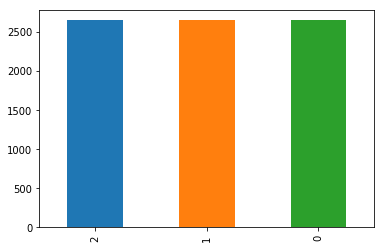

In [198]:
train2 = train.copy()
max_count = np.max(train2['score'].value_counts())
addition = []
for cat in range(3):
    train2_cat = train2[train2['score'] == cat]
    diff = max_count - len(train2_cat)
    addition.append(train2_cat.sample(n=diff, replace=True))
train2 = train2.append(addition, ignore_index=True).reset_index()
train2 = train2.sample(len(train2))
train2['score'].value_counts().plot('bar')

### Naive Bayes

In [212]:
nb_p = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
               ('classifier', MultinomialNB())])
nb_p.fit(train2['review_doc'], train2['score'])
print_metrics(nb_p, train2['review_doc'], train2['score'])

[[2616   27    0]
 [  19 2564   60]
 [  96  181 2366]]
test_f2_score           0.974241
train_accuracy          0.949489
test_accuracy           0.912852
test_f1_macro           0.910893
test_precision_macro    0.918082
test_recall_macro       0.912852
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.308713,0.711216,0.925463,0.923966,0.982743,0.930023,0.925463,0.948922,0.948481,0.984900,0.950037,0.948922
1,0.281950,0.763837,0.898222,0.895795,0.963303,0.903691,0.898222,0.950435,0.950018,0.984225,0.951443,0.950435
2,0.390373,0.674495,0.914869,0.912919,0.976676,0.920531,0.914869,0.949111,0.948696,0.981882,0.950264,0.949111


### Logistic Regression

In [21]:
lr_p = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
                 ('classifier', LogisticRegression())])
lr_p.fit(train2['review_doc'], train2['score'])
print_metrics(lr_p, train2['review_doc'], train2['score'])

[[2643    0    0]
 [   0 2599   44]
 [  52   68 2523]]
test_f2_score           0.991076
train_accuracy          0.977362
test_accuracy           0.959137
test_f1_macro           0.958652
test_precision_macro    0.959998
test_recall_macro       0.959137
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.351063,0.665142,0.959894,0.959364,0.989665,0.961005,0.959894,0.979190,0.979080,0.995818,0.979362,0.979190
1,0.331430,0.645484,0.958381,0.957857,0.991894,0.959498,0.958381,0.976163,0.976051,0.995030,0.976200,0.976163
2,0.330893,0.678880,0.959137,0.958734,0.991670,0.959490,0.959137,0.976731,0.976621,0.995930,0.976792,0.976731


### SVM

In [22]:
from sklearn.svm import SVC

svm_p = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
                 ('classifier', SVC())])
svm_p.fit(train2['review_doc'], train2['score'])
print_metrics(svm_p, train2['review_doc'], train2['score'])

[[2473  120   50]
 [ 328 2001  314]
 [ 413  463 1767]]
test_f2_score           0.886762
train_accuracy          0.787930
test_accuracy           0.767814
test_f1_macro           0.763624
test_precision_macro    0.775935
test_recall_macro       0.767814
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,10.071059,19.903057,0.770337,0.767357,0.881319,0.771479,0.770337,0.788876,0.785078,0.904799,0.790939,0.788876
1,10.098417,19.975930,0.792660,0.788843,0.903784,0.798645,0.792660,0.803632,0.800736,0.903719,0.808637,0.803632
2,10.868719,20.957245,0.740446,0.734673,0.875184,0.757680,0.740446,0.771283,0.766956,0.889822,0.786226,0.771283


### Ensemble

In [213]:
from sklearn.ensemble import VotingClassifier

vcl = VotingClassifier([('nb', nb_p),('tonal', tonal_p), ('lr', lr_p)])
vcl.fit(train2['review_doc'], train2['score'])
print_metrics(vcl, train2['review_doc'], train2['score'])

[[2625   18    0]
 [   0 2589   54]
 [ 101  115 2427]]
test_f2_score           0.979337
train_accuracy          0.961660
test_accuracy           0.926599
test_f1_macro           0.924961
test_precision_macro    0.930502
test_recall_macro       0.926599
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,1.479942,5.144753,0.933409,0.931944,0.982083,0.936833,0.933409,0.960083,0.959807,0.985455,0.960472,0.960083
1,1.496621,4.971172,0.917518,0.915657,0.974084,0.921928,0.917518,0.963867,0.963603,0.988385,0.964393,0.963867
2,1.576440,6.738988,0.928869,0.927282,0.981843,0.932745,0.928869,0.961029,0.960725,0.985241,0.961588,0.961029


We see that results improved, especially Logistic Regression have the best f1

## Downsampled data

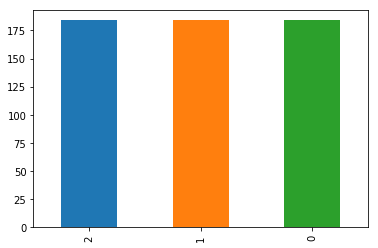

In [24]:
train3 = train.copy()
min_count = np.min(train3['score'].value_counts())
train3_comps = []
for cat in range(3):
    train3_cat = train3[train3['score'] == cat]
    train3_comps.append(train3_cat.sample(n=min_count, replace=True))
train3 = pd.concat(train3_comps, ignore_index=True).reset_index()
train3 = train3.sample(n=len(train3))
train3['score'].value_counts().plot('bar')

### Naive Bayes

In [25]:
nb_p = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
                 ('classifier', MultinomialNB())])
nb_p.fit(train3['review_doc'], train3['score'])
print_metrics(nb_p, train3['review_doc'], train3['score'])

[[180   3   1]
 [  3 181   0]
 [  2  17 165]]
test_f2_score           0.703235
train_accuracy          0.957461
test_accuracy           0.637582
test_f1_macro           0.632070
test_precision_macro    0.675166
test_recall_macro       0.637582
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.037263,0.062412,0.655914,0.659721,0.678808,0.697002,0.655914,0.969945,0.970130,0.977011,0.971235,0.969945
1,0.024726,0.054101,0.672131,0.671266,0.714286,0.699860,0.672131,0.972900,0.972967,0.982143,0.973706,0.972900
2,0.023951,0.055619,0.584699,0.565222,0.716612,0.628638,0.584699,0.929539,0.929221,0.983740,0.939785,0.929539


### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

lr_p = Pipeline([('vectorizer', CountVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
                 ('classifier', LogisticRegression())])
lr_p.fit(train3['review_doc'], train3['score'])
print_metrics(lr_p, train3['review_doc'], train3['score'])

[[183   0   1]
 [  0 182   2]
 [  0   1 183]]
test_f2_score           0.687271
train_accuracy          0.994565
test_accuracy           0.646689
test_f1_macro           0.646432
test_precision_macro    0.650357
test_recall_macro       0.646689
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.035721,0.051874,0.655914,0.655291,0.665584,0.655723,0.655914,0.994536,0.994536,1.000000,0.994536,0.994536
1,0.041402,0.044566,0.683060,0.685035,0.728477,0.694933,0.683060,0.994580,0.994580,1.000000,0.994580,0.994580
2,0.040639,0.049341,0.601093,0.598972,0.667752,0.600415,0.601093,0.994580,0.994591,0.993485,0.994667,0.994580


### SVM

In [27]:
from sklearn.svm import SVC

svm_p = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
                 ('classifier', SVC(C=0.8))])
svm_p.fit(train3['review_doc'], train3['score'])
print_metrics(svm_p, train3['review_doc'], train3['score'])


[[158  11  15]
 [ 11 159  14]
 [  2  25 157]]
test_f2_score           0.640942
train_accuracy          0.875976
test_accuracy           0.601357
test_f1_macro           0.597747
test_precision_macro    0.622018
test_recall_macro       0.601357
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.075635,0.151197,0.618280,0.613314,0.557491,0.654678,0.618280,0.901639,0.901368,0.898502,0.903727,0.901639
1,0.073104,0.151084,0.617486,0.610401,0.736196,0.639994,0.617486,0.861789,0.861907,0.913978,0.880689,0.861789
2,0.072763,0.155326,0.568306,0.569525,0.629139,0.571382,0.568306,0.864499,0.864574,0.895765,0.864669,0.864499


Let's stick with logistic regression and use more features with upsamped dataset

### Linear Regression

In [29]:
lr_p = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, tokenizer=lambda x: x, vocabulary=vocab)),
                 ('classifier', LogisticRegression())])
lr_p.fit(train2['review_doc'], train2['score'])
print_metrics(lr_p, train2)

[[2643    0    0]
 [   0 2599   44]
 [  52   68 2523]]
test_f2_score           0.991076
train_accuracy          0.977362
test_accuracy           0.959137
test_f1_macro           0.958652
test_precision_macro    0.959998
test_recall_macro       0.959137
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,0.386821,0.692024,0.959894,0.959364,0.989665,0.961005,0.959894,0.979190,0.979080,0.995818,0.979362,0.979190
1,0.347478,0.653973,0.958381,0.957857,0.991894,0.959498,0.958381,0.976163,0.976051,0.995030,0.976200,0.976163
2,0.340198,0.681023,0.959137,0.958734,0.991670,0.959490,0.959137,0.976731,0.976621,0.995930,0.976792,0.976731


let's use feature "contains CAPS" 

In [193]:
CAPS = train['main_review'].str.contains(r'[А-ЯЄI]{4,}')
class HasCapsExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        return [{'has_caps': int(v)}
               for v in df['main_review'].str.contains(r'[А-ЯЄI]{4,}')]
    

In [ ]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key, default=None):
        self.key = key
        self.default = default
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X[self.key]
        else:
            return [x.get(self.key, self.default) for x in X]


In [ ]:
not_words = {'не','ніколи','нізащо'}
def prepend_not(doc):
    new_doc = doc.copy()
    maxidx = len(doc) - 1
    args_idxs = set()
    for i,tok in enumerate(new_doc):
        if tok in not_words:
            args_idxs.update([min(i+1, maxidx), min(i+2, maxidx)])
    for idx in args_idxs:
        new_doc[idx] = "не_" + doc[idx]
    return new_doc

class NotPrepender(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.Series):
            return X.apply(prepend_not)
        else:
            return [prepend_not(x) for x in X]

In [206]:
tokenizer = lambda x: prepend_not(stem(tokenize(x)))
pipe = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('main_bow', Pipeline([
                ('selector', ItemSelector(key='review_dict')),
                ('pros_selector', ItemSelector(key='_', default='')),
                ('vect', TfidfVectorizer(lowercase=False, tokenizer=tokenizer, vocabulary=vocab))
            ])),
            ('pros', Pipeline([
                ('selector', ItemSelector(key='review_dict')),
                ('pros_selector', ItemSelector(key='Переваги:', default='')),
                ('vect', TfidfVectorizer(lowercase=True, tokenizer=tokenizer))
            ])),
            ('cons', Pipeline([
                ('selector', ItemSelector(key='review_dict')),
                ('cons_selector', ItemSelector(key='Недоліки:', default='')),
                ('vect', TfidfVectorizer(lowercase=True, tokenizer=tokenizer))
            ])),
            ('has_caps', Pipeline([
                ('extranctor', HasCapsExtractor()),
                ('vect', DictVectorizer())
            ]))
        ]
    )),
    ('classifier', LogisticRegression())
])
pipe.fit(train2, train2['score'])

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('main_bow', Pipeline(memory=None,
     steps=[('selector', ItemSelector(default=None, key='review_dict')), ('pros_selector', ItemSelector(default='', key='_')), ('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='str...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [197]:
print_metrics(pipe, train2, train2['score'])

[[2643    0    0]
 [   0 2643    0]
 [  11   22 2610]]
test_f2_score           0.994956
train_accuracy          0.994577
test_accuracy           0.975281
test_f1_macro           0.975061
test_precision_macro    0.976147
test_recall_macro       0.975281
dtype: float64


,fit_time,score_time,test_accuracy,test_f1_macro,test_f2_score,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_f2_score,train_precision_macro,train_recall_macro
0,6.396143,14.919582,0.974272,0.974067,0.995705,0.975070,0.974272,0.994135,0.994127,0.999093,0.994163,0.994135
1,6.085128,16.940590,0.975407,0.975167,0.994132,0.976314,0.975407,0.994325,0.994314,0.998866,0.994378,0.994325
2,6.346964,16.025862,0.976163,0.975949,0.995030,0.977056,0.976163,0.995271,0.995262,0.998866,0.995305,0.995271


Pretty good results

## Test set performance

In [208]:
from sklearn.metrics import f1_score
test_pred = pipe.predict(test)
print('f2_score:', f2_score(pipe, test, test['score']))
print('f1_macro:', f1_score(test['score'], test_pred, average='macro'))
confusion_matrix(test['score'], test_pred)

f2_score: [0.51613]
f1_macro: 0.5407395749681909


array([[  48,   11,   33],
       [  23,   12,   44],
       [  26,   35, 1064]])

We've got pretty low test performance :(